# Before you begin, make sure to activate the virtual environment using the following command:
# On Windows, in your VSCode terminal run:
# myenv\Scripts\activate



In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.api import VAR
import pymc as pm
import arviz as az
from scipy.stats import invwishart
from statsmodels.stats.diagnostic import acorr_ljungbox

In [21]:
!conda install m2w64-toolchain

Channels:
 - defaults
Platform: win-64
Solving environment: ...working... done

# All requested packages already installed.



C:\Users\yacou\Miniconda3\Lib\site-packages\conda\base\context.py:201: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(


In [22]:
# Définir les indices à télécharger
indices = {
    '^GSPC': 'S&P 500',
    '^FCHI': 'CAC 40',
    '^GDAXI': 'DAX',
    '^FTSE': 'FTSE 100'
    }

# Téléchargement des données (période : janvier 2023 - décembre 2023)
start_date = "2023-01-01"
end_date = "2023-12-31"
data =yf.download(list(indices.keys()), start=start_date, end=end_date)['Close']
data = data.rename(columns=indices)
# Affichage des 5 premières lignes
data.head()

[*********************100%***********************]  4 of 4 completed


Ticker,CAC 40,FTSE 100,DAX,S&P 500
Date,,,,
2023-01-02,6594.569824,NaN,14069.259766,NaN
2023-01-03,6623.890137,7554.100098,14181.669922,3824.139893
2023-01-04,6776.430176,7585.200195,14490.780273,3852.969971
2023-01-05,6761.500000,7633.500000,14436.309570,3808.100098
2023-01-06,6860.950195,7699.500000,14610.019531,3895.080078


In [23]:
# Calcul des rendements logarithmiques
log_returns = np.log(data / data.shift(1)).dropna()

# Affichage des 5 premières lignes
log_returns.head()


Ticker,CAC 40,FTSE 100,DAX,S&P 500
Date,,,,
2023-01-04,0.022768,0.004109,0.021562,0.007511
2023-01-05,-0.002206,0.006347,-0.003766,-0.011714
2023-01-06,0.014601,0.008609,0.011961,0.022584
2023-01-09,0.006742,0.003293,0.012435,-0.000768
2023-01-10,-0.005549,-0.003943,-0.001233,0.006954


In [24]:
# Vérification des données manquantes
print("Données manquantes par colonne :")
print(log_returns.isnull().sum())


Données manquantes par colonne :
Ticker
CAC 40      0
FTSE 100    0
DAX         0
S&P 500     0
dtype: int64


In [25]:
# Fonction pour effectuer le test ADF
def adf_test(series, alpha=0.05):
    result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critique values: {result[4]}")
    if result[1] <= alpha:
        print("La série est stationnaire (rejette H0).")
    else:
        print("La série n'est pas stationnaire (ne rejette pas H0).")

# Application du test ADF pour chaque indice
print("\n--- Test ADF ---")
for col in log_returns.columns:
    print(f"\nIndice : {col}")
    adf_test(log_returns[col])



--- Test ADF ---

Indice : CAC 40
ADF Statistic: -17.14764988622996
p-value: 6.976603247794968e-30
Critique values: {'1%': -3.4589796764641, '5%': -2.8741347158661448, '10%': -2.573482381701992}
La série est stationnaire (rejette H0).

Indice : FTSE 100
ADF Statistic: -9.686579368608818
p-value: 1.166226336684023e-16
Critique values: {'1%': -3.459105583381277, '5%': -2.8741898504150574, '10%': -2.5735117958412097}
La série est stationnaire (rejette H0).

Indice : DAX
ADF Statistic: -16.597020770078917
p-value: 1.7781565491275004e-29
Critique values: {'1%': -3.4589796764641, '5%': -2.8741347158661448, '10%': -2.573482381701992}
La série est stationnaire (rejette H0).

Indice : S&P 500
ADF Statistic: -15.263631220440056
p-value: 4.822700969199534e-28
Critique values: {'1%': -3.4589796764641, '5%': -2.8741347158661448, '10%': -2.573482381701992}
La série est stationnaire (rejette H0).


In [26]:
# Calcul des statistiques descriptives
print("\n--- Statistiques Descriptives ---")
log_returns.describe()



--- Statistiques Descriptives ---


Ticker,CAC 40,FTSE 100,DAX,S&P 500
count,232.000000,232.000000,232.000000,232.000000
mean,0.000680,0.000215,0.000785,0.001045
std,0.008850,0.007280,0.008362,0.008309
min,-0.036484,-0.039066,-0.033210,-0.018632
25%,-0.003864,-0.003448,-0.003094,-0.004164
50%,0.001041,0.000804,0.000923,0.000992
75%,0.006208,0.004057,0.005671,0.006706
max,0.022768,0.019357,0.021562,0.022584


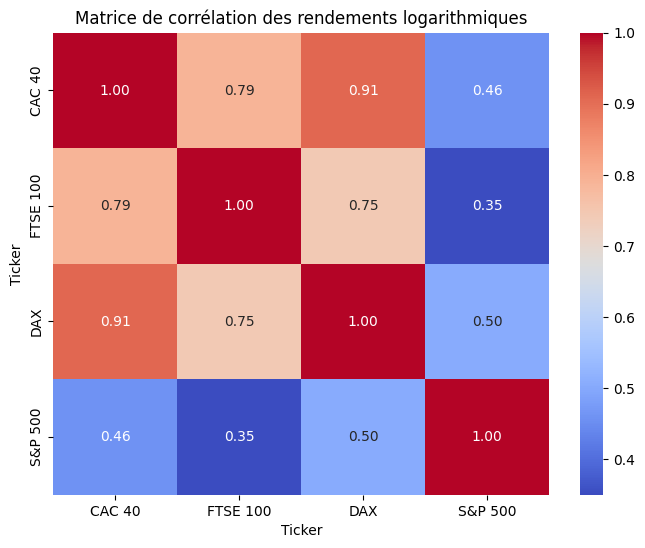

In [27]:
# Matrice de corrélation
correlation_matrix = log_returns.corr()
# Visualisation de la matrice de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation des rendements logarithmiques")
plt.show()


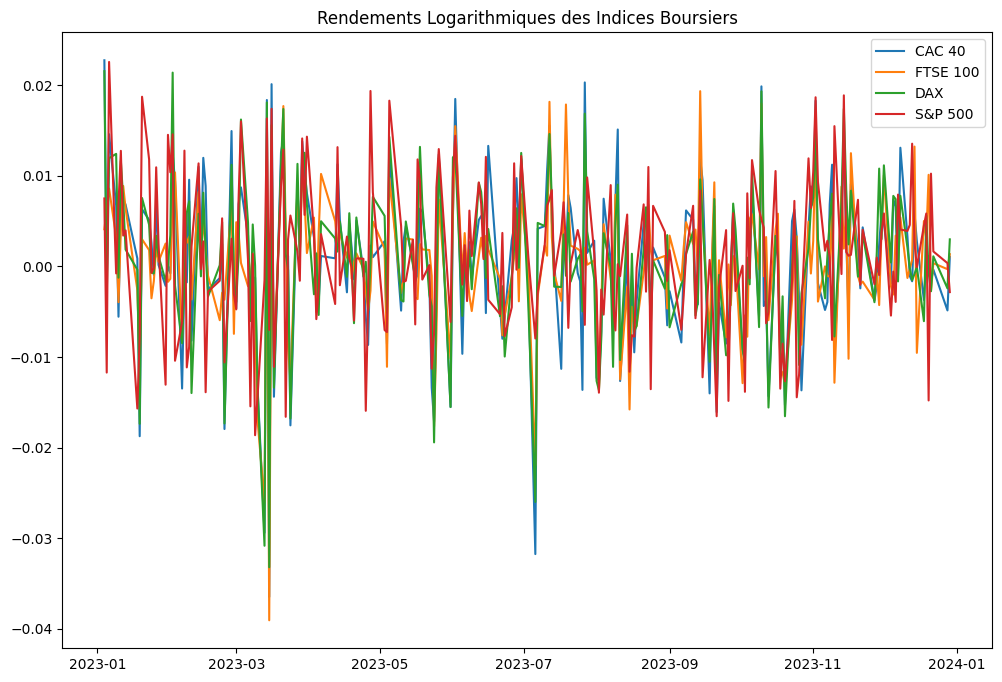

In [28]:
# Tracer les séries temporelles des rendements logarithmiques
plt.figure(figsize=(12, 8))
for col in log_returns.columns:
    plt.plot(log_returns[col], label=col)
plt.title("Rendements Logarithmiques des Indices Boursiers")
plt.legend()
plt.show()


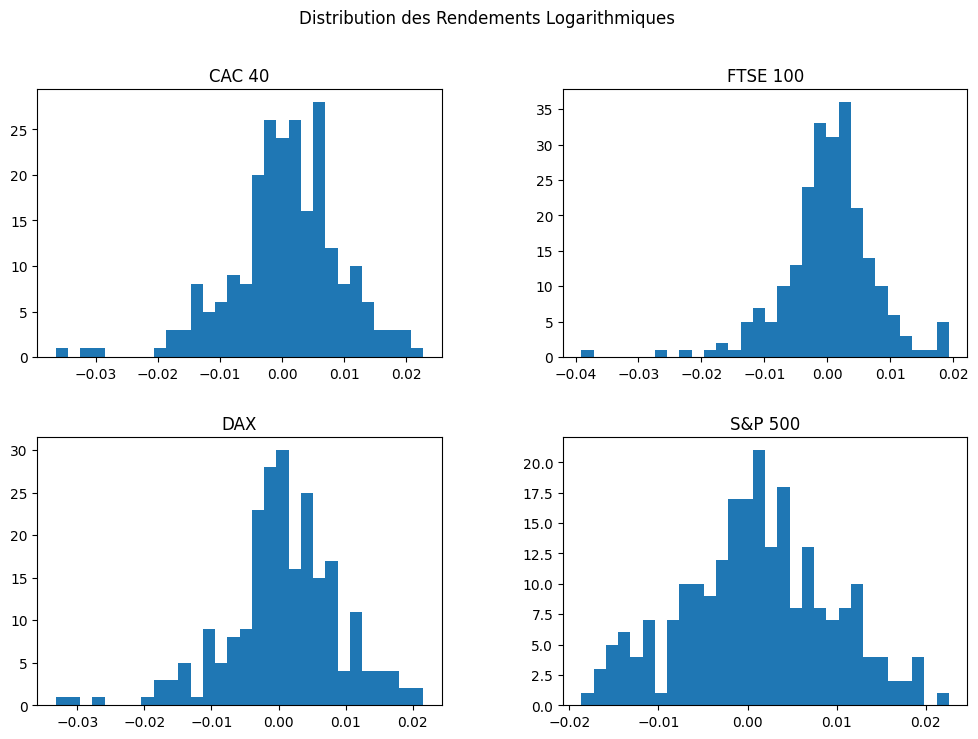

In [29]:
# Histogrammes pour chaque indice
log_returns.hist(bins=30, figsize=(12, 8), grid=False)
plt.suptitle("Distribution des Rendements Logarithmiques")
plt.show()


<Figure size 640x480 with 0 Axes>

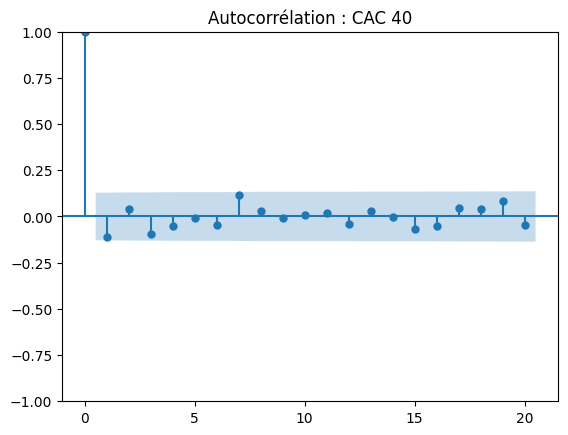

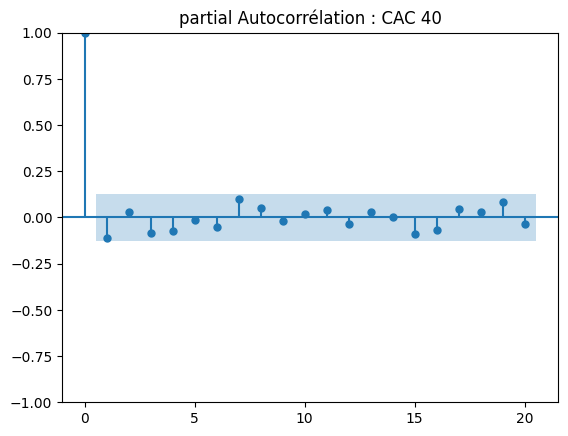

<Figure size 640x480 with 0 Axes>

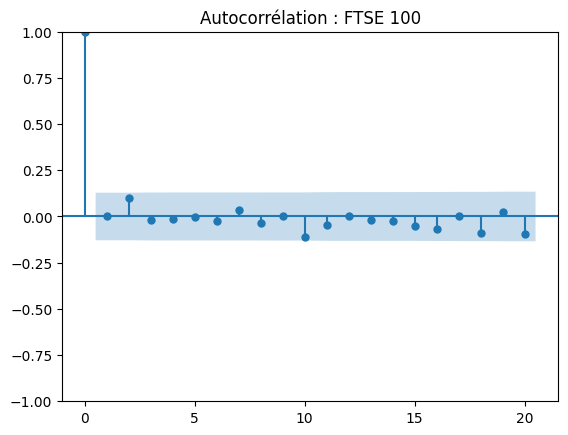

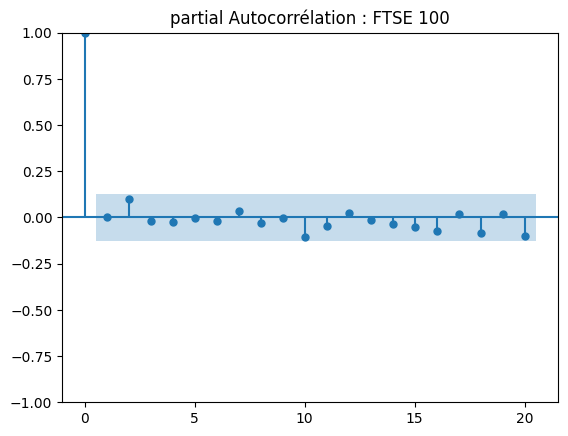

<Figure size 640x480 with 0 Axes>

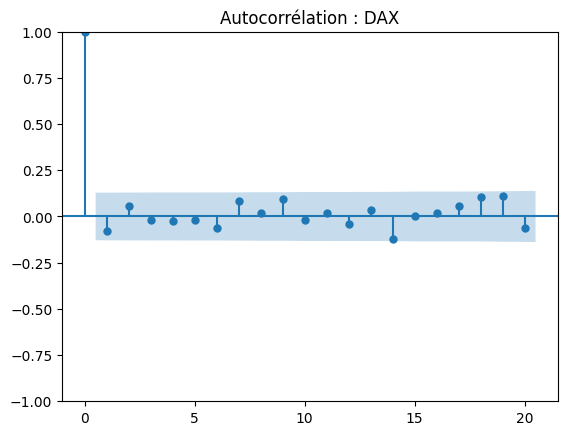

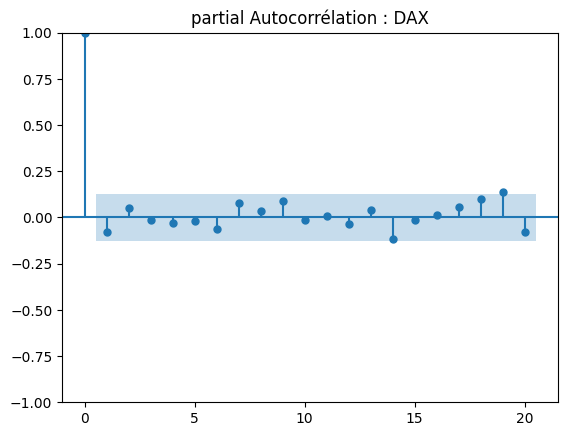

<Figure size 640x480 with 0 Axes>

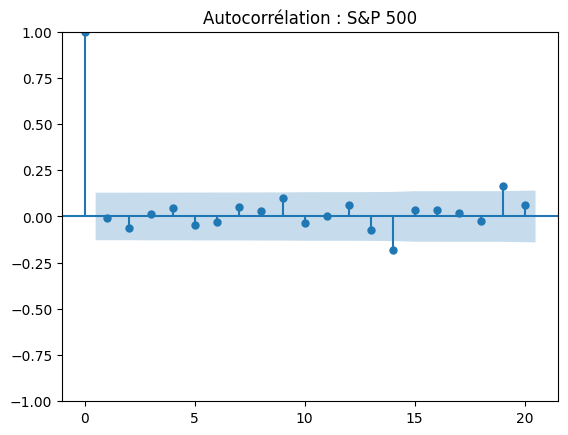

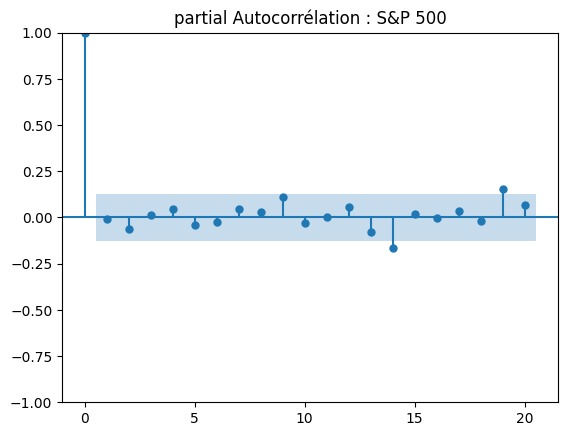

In [30]:
# Tracer l'autocorrélation pour chaque indice
for col in log_returns.columns:
    plt.figure()
    plot_acf(log_returns[col], lags=20, title=f"Autocorrélation : {col}")
    plot_pacf(log_returns[col], lags=20, title=f"partial Autocorrélation : {col}")
    plt.show()


In [31]:
# Ajustement du modèle VAR
model = VAR(log_returns)

# Sélection de l'ordre optimal (nombre de lags) basé sur les critères d'information (AIC, BIC)
lag_order_results = model.select_order(maxlags=10)
print("Ordre optimal selon les critères d'information :")
print(lag_order_results.summary())



Ordre optimal selon les critères d'information :
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -41.53     -41.47*   9.180e-19     -41.51*
1      -41.56*      -41.26  8.902e-19*      -41.44
2       -41.51      -40.95   9.429e-19      -41.28
3       -41.43      -40.64   1.015e-18      -41.11
4       -41.42      -40.38   1.025e-18      -41.00
5       -41.33      -40.04   1.126e-18      -40.81
6       -41.24      -39.71   1.230e-18      -40.62
7       -41.18      -39.40   1.315e-18      -40.46
8       -41.12      -39.10   1.400e-18      -40.30
9       -41.06      -38.79   1.497e-18      -40.14
10      -40.99      -38.47   1.611e-18      -39.97
--------------------------------------------------


c:\Users\yacou\Downloads\Nouveau dossier (2)\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [32]:
# Ajustement du modèle avec l'ordre optimal
optimal_lag = lag_order_results.aic
var_model = model.fit(optimal_lag)

# Résumé des coefficients estimés
print("\n--- Résumé du Modèle VAR ---")
print(var_model.summary())


--- Résumé du Modèle VAR ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 24, Jan, 2025
Time:                     21:00:41
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -41.2589
Nobs:                     231.000    HQIC:                  -41.4368
Log likelihood:           3508.73    FPE:                8.95457e-19
AIC:                     -41.5570    Det(Omega_mle):     8.21949e-19
--------------------------------------------------------------------
Results for equation CAC 40
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.000479         0.000562            0.851           0.395
L1.CAC 40          -0.309134         0.165639           -1.866           0.062
L1.FTSE 100         0.173150         


--- Test de Ljung-Box sur les résidus ---
Résultats pour CAC 40 :
    lb_stat  lb_pvalue
1  0.090637   0.763369
Résultats pour FTSE 100 :
    lb_stat  lb_pvalue
1  0.031415   0.859317
Résultats pour DAX :
    lb_stat  lb_pvalue
1  0.086107   0.769186
Résultats pour S&P 500 :
    lb_stat  lb_pvalue
1  0.012859   0.909714


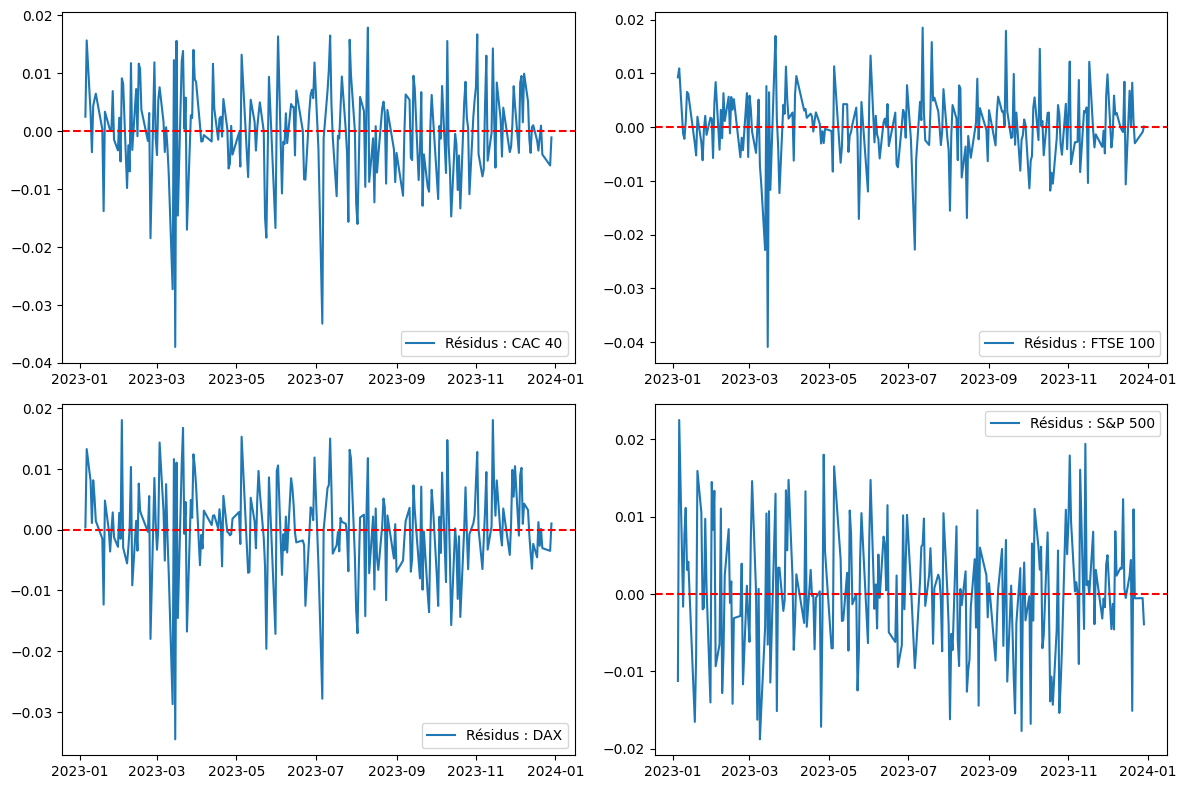

In [33]:
residuals = var_model.resid

# Test de Ljung-Box sur les résidus
print("\n--- Test de Ljung-Box sur les résidus ---")
for col in residuals.columns:
    ljung_test = acorr_ljungbox(residuals[col], lags=[1], return_df=True)
    print(f"Résultats pour {col} :")
    print(ljung_test)

# Tracé des résidus
plt.figure(figsize=(12, 8))
for i, col in enumerate(residuals.columns):
    plt.subplot(2, 2, i + 1)
    plt.plot(residuals[col], label=f"Résidus : {col}")
    plt.axhline(0, color='red', linestyle='--')
    plt.legend()
plt.tight_layout()
plt.show()


In [34]:
# Prévisions sur les 30 prochains pas de temps
forecast_steps = 8
forecast = var_model.forecast(y=log_returns.values[-optimal_lag:], steps=forecast_steps)

# Conversion des prévisions en DataFrame
forecast_index = pd.date_range(start=log_returns.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=log_returns.columns)

# Affichage des prévisions
print("\n--- Prévisions des rendements logarithmiques ---")
print(forecast_df)



--- Prévisions des rendements logarithmiques ---
Ticker        CAC 40  FTSE 100       DAX   S&P 500
2024-01-01 -0.000611 -0.001059 -0.000776  0.000363
2024-01-02  0.000631  0.000166  0.000760  0.001234
2024-01-03  0.000643  0.000258  0.000755  0.001031
2024-01-04  0.000595  0.000202  0.000702  0.001011
2024-01-05  0.000597  0.000202  0.000704  0.001020
2024-01-08  0.000599  0.000204  0.000706  0.001020
2024-01-09  0.000599  0.000204  0.000706  0.001020
2024-01-10  0.000598  0.000204  0.000706  0.001020


In [35]:
# Définir la période des données de test (après les données d'entraînement)
test_start_date = forecast_index[0]
test_end_date = forecast_index[-1]
# Téléchargement des données réelles pour la période des prévisions
test_data = yf.download(list(indices.keys()), start=test_start_date, end=test_end_date)['Close']
# Conversion en DataFrame
test_data=test_data.rename(columns=indices)
# Calcul des rendements logarithmiques pour les données de test
test_log_returns = np.log(test_data / test_data.shift(1)).dropna()
# Affichage des données de test
print("\n--- Données de Test (Rendements Logarithmiques) ---")
print(test_log_returns)


[*********************100%***********************]  4 of 4 completed


--- Données de Test (Rendements Logarithmiques) ---
Ticker        CAC 40  FTSE 100       DAX   S&P 500
Date                                              
2024-01-03 -0.015928 -0.005090 -0.013869 -0.008049
2024-01-04  0.005217  0.005297  0.004759 -0.003434
2024-01-05 -0.004027 -0.004347 -0.001390  0.001824
2024-01-08  0.003974  0.000598  0.007341  0.014016
2024-01-09 -0.003175 -0.001327 -0.001683 -0.001479


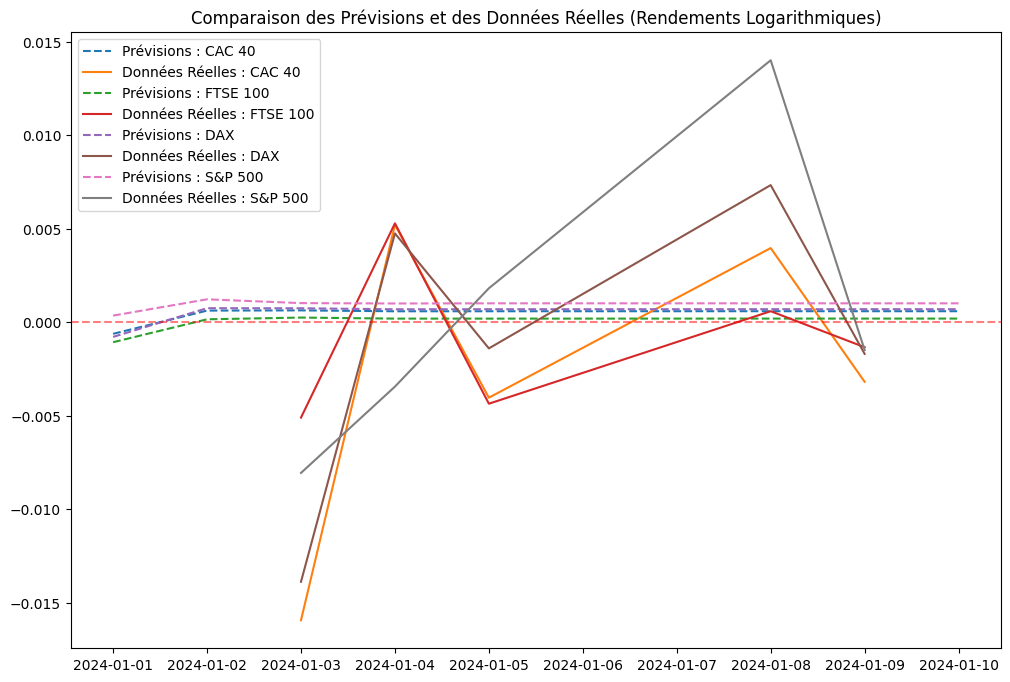

In [36]:
# Tracé des prévisions vs données réelles
plt.figure(figsize=(12, 8))
for col in log_returns.columns:
    plt.plot(forecast_index, forecast_df[col], label=f"Prévisions : {col}", linestyle='--')
    if col in test_log_returns.columns:
        plt.plot(test_log_returns.index, test_log_returns[col], label=f"Données Réelles : {col}", linestyle='-')

plt.legend()
plt.title("Comparaison des Prévisions et des Données Réelles (Rendements Logarithmiques)")
plt.axhline(0, color="red", linestyle="--", alpha=0.5)
plt.show()


In [37]:
# Configuration du modèle PyMC
with pm.Model() as bayesian_var:
    # Inférence
    # Priors sur les coefficients du modèle (régression multivariée)
    beta = pm.Normal("beta", mu=0, sigma=0.1, shape=(optimal_lag, len(log_returns.columns)))
    # Prior sur la matrice de covariance (Inverse-Wishart)
    nu = len(log_returns.columns) + 1
    scale_matrix = np.eye(len(log_returns.columns))
    sigma = pm.LKJCholeskyCov("sigma", n=len(log_returns.columns), eta=1, sd_dist=pm.HalfCauchy.dist(0.1))
    # Définir les observations (log_returns)
    obs = log_returns.values[optimal_lag:]
    print(obs.shape)
    # Liste pour stocker les prédictions
    preds = []
    for t in range(optimal_lag, len(log_returns)):
        # Valeurs décalées (lagged values)
        lagged_values = log_returns.values[t-optimal_lag:t]
        # Calculer la prédiction
        pred = pm.math.dot(lagged_values, beta.T)
        preds.append(pred)
    
    # Empiler les prédictions (stack predictions)
    predictions = pm.Deterministic("predictions", pm.math.stack(preds, axis=0))

# Vérification des formes des prédictions et des observations
    # Inférence
    trace = pm.sample(100, tune=100, target_accept=0.9, return_inferencedata=True)

    print("Shape of predictions:", predictions.shape)  # (n_samples, n_features)
    print("Shape of observations (obs):", obs.shape)


(231, 4)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 147 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Shape of predictions: Shape.0
Shape of observations (obs): (231, 4)


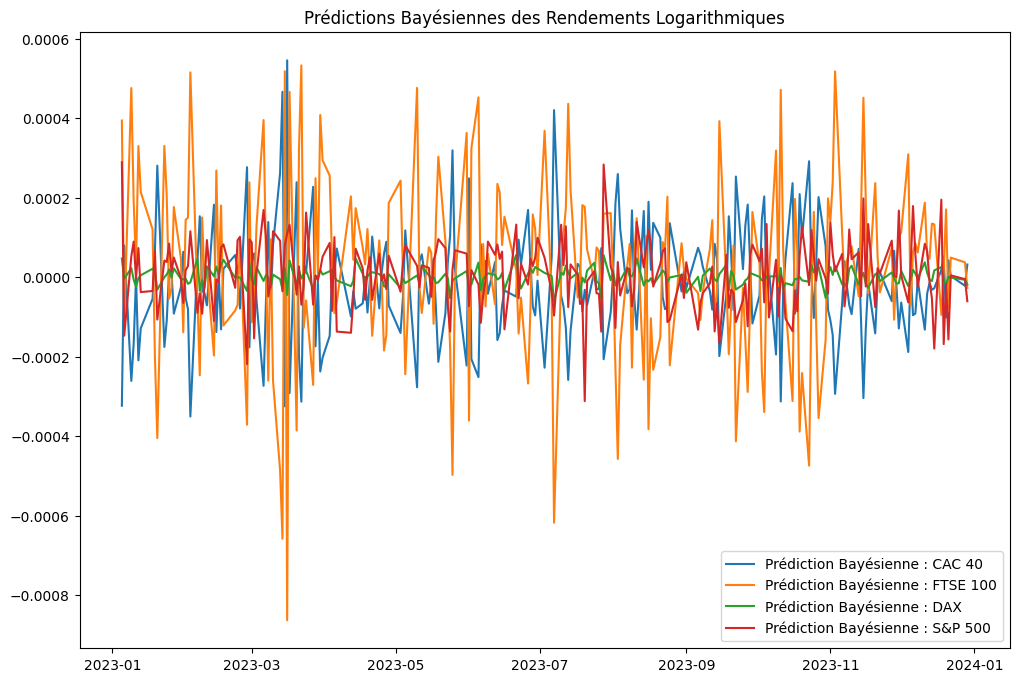

In [38]:
# Extraction des prédictions bayésiennes
bayesian_preds = trace.posterior["predictions"].values

# Supprimer les dimensions inutiles de taille 1 (dimensions 3 et 4)
bayesian_preds = np.squeeze(bayesian_preds)

# Moyenne sur la dimension des chaînes (dimension 1)
bayesian_preds_mean = bayesian_preds.mean(axis=1)

# Convertir les prédictions en DataFrame
bayesian_preds_df = pd.DataFrame(bayesian_preds_mean.T, index=log_returns.index[optimal_lag:], columns=log_returns.columns)

# Tracé des prédictions
plt.figure(figsize=(12, 8))
for col in bayesian_preds_df.columns:
    plt.plot(bayesian_preds_df.index, bayesian_preds_df[col], label=f"Prédiction Bayésienne : {col}")
plt.legend()
plt.title("Prédictions Bayésiennes des Rendements Logarithmiques")
plt.show()


In [39]:
# Modèle `bayesian_enc` (avec D)
with pm.Model() as bayesian_enc:
    # Priors ENC
    D_0 = np.zeros((optimal_lag * len(log_returns.columns), len(log_returns.columns)))
    nu = len(log_returns.columns) + 1
    scale_matrix = np.eye(len(log_returns.columns)) * 0.1

    # Priors sur les coefficients
    D = pm.Normal("D", mu=D_0, sigma=0.1, shape=(optimal_lag * len(log_returns.columns), len(log_returns.columns)))

    # Prior sur la matrice de covariance (Inverse-Wishart)
    sigma_enc = pm.LKJCholeskyCov("sigma_enc", eta=1, n=len(log_returns.columns), sd_dist=pm.HalfCauchy.dist(0.1))

    # Vraisemblance
    obs_enc = log_returns.values[optimal_lag:]
    preds_enc = []

    for t in range(optimal_lag, len(log_returns)):
        # Valeurs décalées (lagged values)
        lagged_values = log_returns.values[t - optimal_lag:t].reshape(1, -1)
        pred_enc = pm.math.dot(lagged_values, D.T)
        preds_enc.append(pred_enc)

    predictions_enc = pm.Deterministic("predictions_enc", pm.math.stack(preds_enc, axis=0))


    # Inférence
    trace_enc = pm.sample(100, tune=100, target_accept=0.9, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D, sigma_enc]


Output()

Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 181 seconds.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


(4, 231)


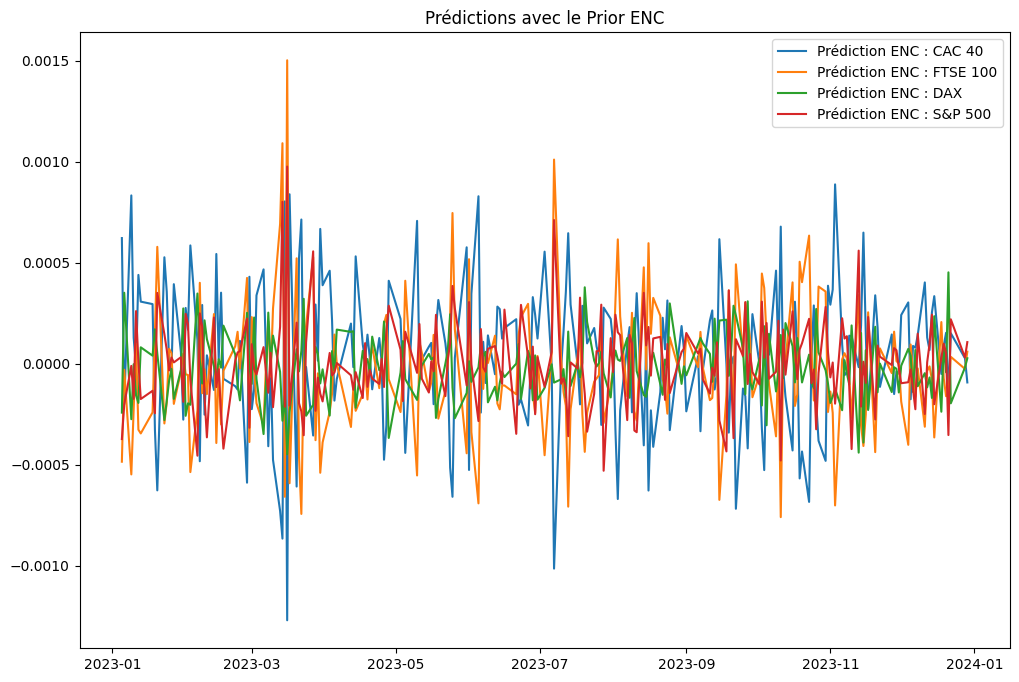

In [40]:

# Extraction des prédictions bayésiennes
bayesian_preds_enc = trace_enc.posterior["predictions_enc"].values

# Supprimer les dimensions inutiles de taille 1 (dimensions 3 et 4)
bayesian_preds_enc = np.squeeze(bayesian_preds_enc)
bayesian_preds_enc = np.squeeze(bayesian_preds_enc[:,:,0:,:1])

# Moyenne sur la dimension des chaînes (dimension 1)
bayesian_preds_enc_mean = bayesian_preds_enc.mean(axis=1)
print(bayesian_preds_enc_mean.shape)
enc_preds = pd.DataFrame(bayesian_preds_enc_mean.T, index=log_returns.index[optimal_lag:], columns=log_returns.columns)

plt.figure(figsize=(12, 8))
for col in enc_preds.columns:
    plt.plot(enc_preds.index, enc_preds[col], label=f"Prédiction ENC : {col}")
    plt.legend()
plt.title("Prédictions avec le Prior ENC")
plt.show()


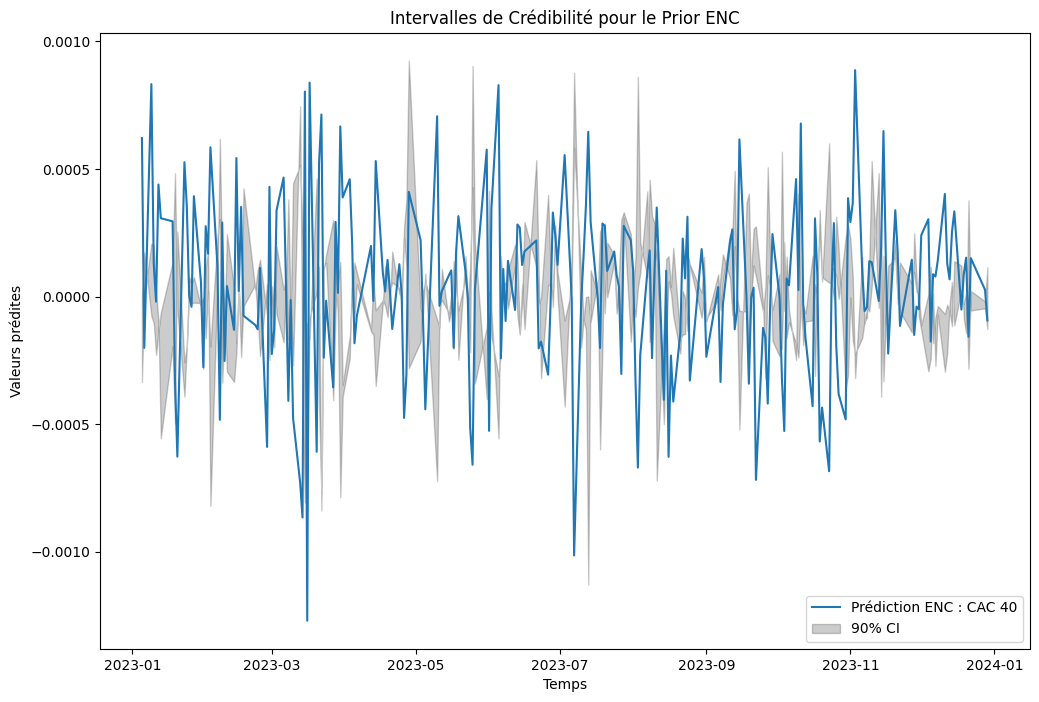

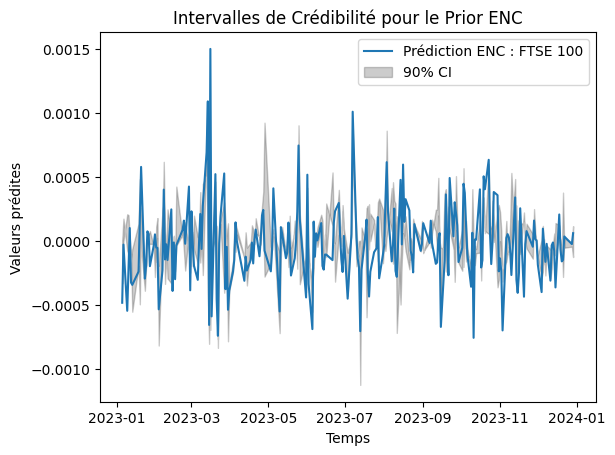

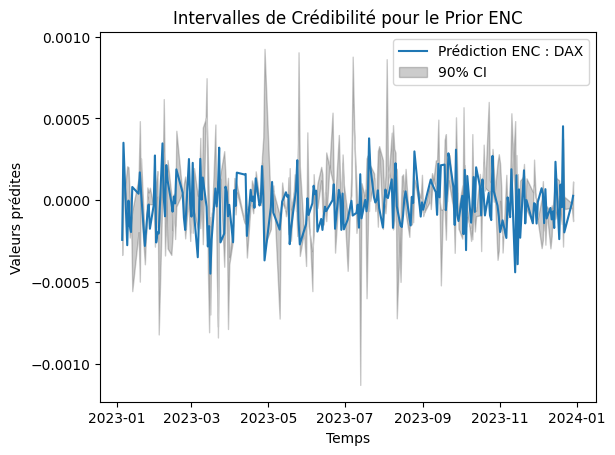

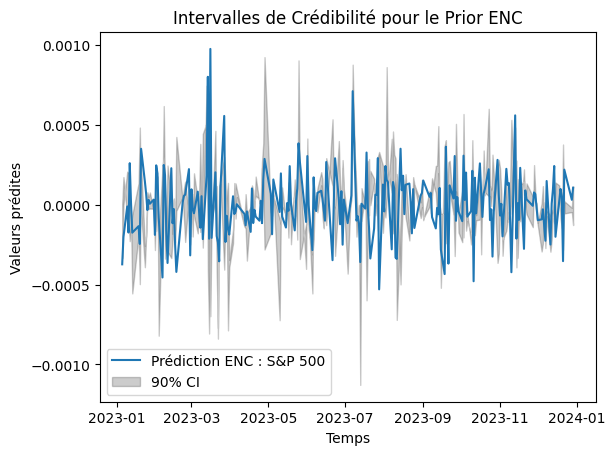

In [41]:

# Calcul des intervalles de crédibilité pour le prior ENC
enc_hpd = az.hdi(trace_enc, hdi_prob=0.9)["predictions_enc"]
# Aplatir les intervalles de crédibilité
lower = enc_hpd[:, :, 0]  # Borne inférieure
upper = enc_hpd[:, :, 1]  # Borne supérieure

# Moyenne des intervalles de crédibilité
enc_hpd_df = pd.DataFrame({
    "lower": np.squeeze(lower.mean(axis=2)),
    "upper": np.squeeze(upper.mean(axis=2))
}, index=log_returns.index[optimal_lag:])

# Tracé des intervalles
plt.figure(figsize=(12, 8))
for col in enc_preds.columns:
    # Tracer les prédictions
    plt.plot(enc_preds.index, enc_preds[col], label=f"Prédiction ENC : {col}")
    
    # Tracer les intervalles de crédibilité
    plt.fill_between(enc_preds.index, enc_hpd_df["lower"], enc_hpd_df["upper"], 
                     color="black", alpha=0.2, label="90% CI")

    plt.legend()
    plt.title("Intervalles de Crédibilité pour le Prior ENC")
    plt.xlabel("Temps")
    plt.ylabel("Valeurs prédites")
    plt.show()



<Figure size 1200x800 with 0 Axes>

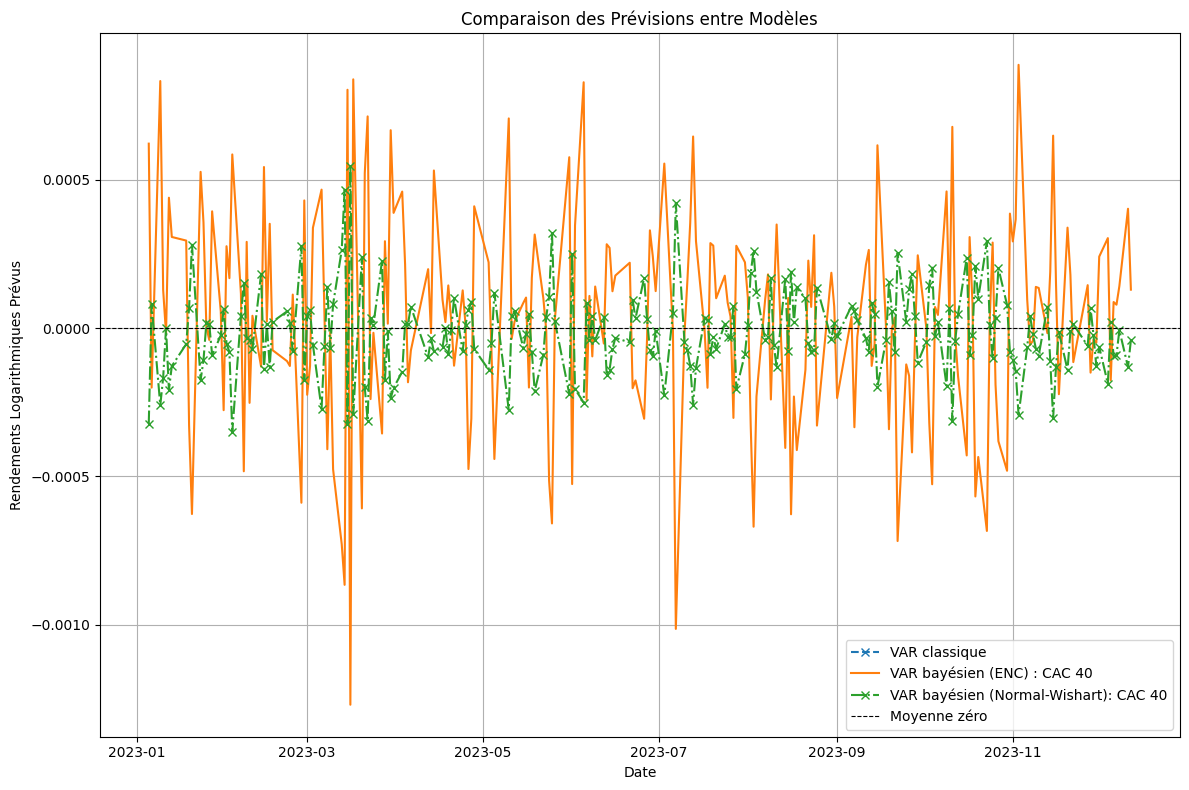

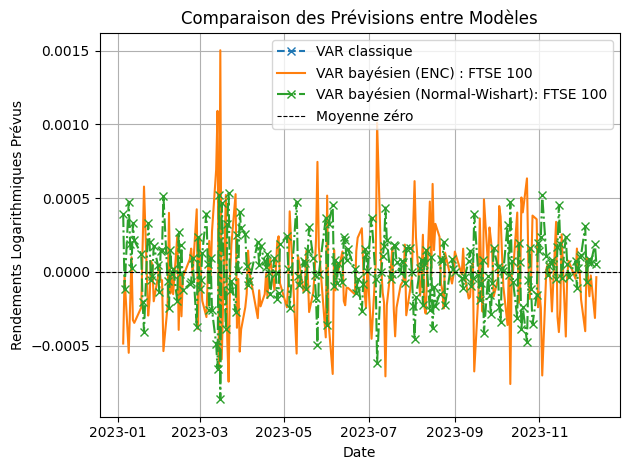

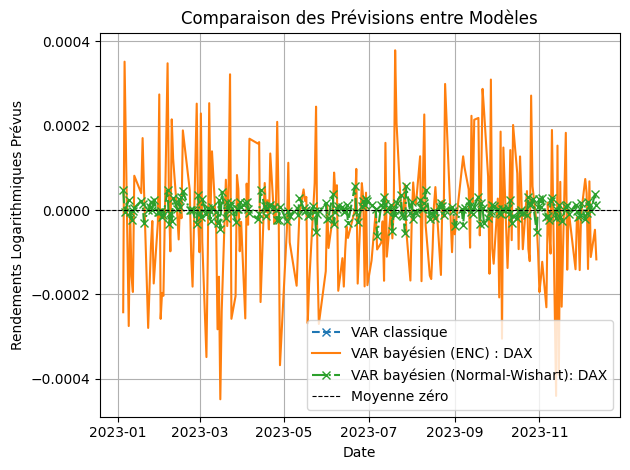

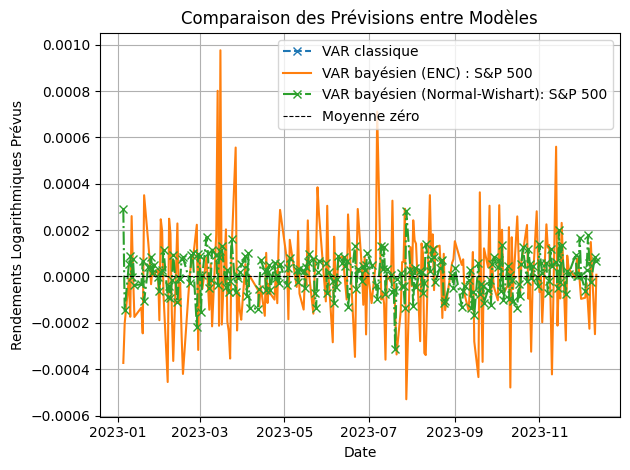

In [42]:
plt.figure(figsize=(12, 8))
plt.figure(figsize=(12, 8))
for col in enc_preds.columns:
    # Prévisions du modèle VAR classique
    plt.plot(forecast_index[:-10], forecast_df[col].values[:-10], label="VAR classique", linestyle="--", marker="x")
    plt.plot(enc_preds.index[:-10], enc_preds[col][:-10], label=f"VAR bayésien (ENC) : {col}")
    plt.plot(bayesian_preds_df.index[:-10], bayesian_preds_df[col][:-10], label=f"VAR bayésien (Normal-Wishart): {col}", linestyle="-.", marker="x")
    # Ligne de référence pour la moyenne zéro (optionnelle pour les rendements)
    plt.axhline(0, color="black", linestyle="--", linewidth=0.8, label="Moyenne zéro")
    plt.legend()
    # Détails du graphique
    plt.title("Comparaison des Prévisions entre Modèles")
    plt.xlabel("Date")
    plt.ylabel("Rendements Logarithmiques Prévus")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
# Affichage
    plt.show()


In [43]:
# Fonction pour calculer le RMSE
def calculate_rmse(true, predicted):
    return np.sqrt(np.mean((true - predicted) ** 2))

# Vraies valeurs (décalées pour correspondre aux prévisions)
true_values = log_returns.iloc[optimal_lag:]

# Calcul du RMSE pour chaque indice et modèle
rmse_results = {
    "Indice": log_returns.columns,
    "VAR classique": [calculate_rmse(true_values[col], var_model.fittedvalues[col]) for col in log_returns.columns],
    "VAR bayésien (Normal-Wishart)": [calculate_rmse(true_values[col], bayesian_preds_df[col]) for col in log_returns.columns],
    "VAR bayésien (ENC)": [calculate_rmse(true_values[col], enc_preds[col]) for col in log_returns.columns],
}

# Conversion des RMSE en DataFrame
rmse_df = pd.DataFrame(rmse_results)
print("\n--- RMSE pour chaque modèle et indice ---")
print(rmse_df)



--- RMSE pour chaque modèle et indice ---
     Indice  VAR classique  VAR bayésien (Normal-Wishart)  VAR bayésien (ENC)
0    CAC 40       0.008369                       0.008746            0.008748
1  FTSE 100       0.006876                       0.007258            0.007295
2       DAX       0.007856                       0.008281            0.008304
3   S&P 500       0.008221                       0.008360            0.008339
